In [93]:
#----------------------------------------------
# Import Libraries
#----------------------------------------------

import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import linear_model

from sklearn.feature_selection import RFE
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import make_scorer, r2_score, mean_squared_error, auc, mean_absolute_error
from sklearn.model_selection import GridSearchCV, KFold
# from sklearn.cross_validation import KFold # old version

from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt

cur_dir = os.getcwd()

# Step 1 - Data Cleaning and Data Preparation

In [14]:
# Using a small subset of original data
# full data can be found on Kaggle : https://www.kaggle.com/c/job-salary-prediction
Salaries = pd.read_csv("Salary_Train_sample.csv", encoding = "ISO-8859-1") 
Salaries_Train,Salaries_Test = train_test_split(Salaries,test_size=0.33, random_state=13)

In [3]:
Salaries.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


Data prep function - explanations for each step provided below

In [16]:
# Function to Clean Data - Explanations Provided in Cells Below

def clean_null(Salaries):
    Salaries.dropna(subset=['Title'],inplace=True)
    Salaries['ContractType'].fillna(Salaries['ContractType'].mode()[0],inplace=True)
    Salaries.loc[Salaries['ContractTime'].isnull(), 'ContractTime'] = 'Unknown'
    Salaries.loc[Salaries['Company'].isnull(), 'Company'] = 'Unknown'
    return Salaries

In [5]:
def featurize(Salaries_Train, Salaries_Test):

    vectorizer = CountVectorizer(analyzer = "word", 
                                 tokenizer = None, 
                                 preprocessor = None, 
                                 stop_words = 'english', 
                                 max_features = 200,
                                 ngram_range = (1,2))\
                                .fit(Salaries_Train['FullDescription']) 
    
    train_words = vectorizer.transform(Salaries_Train['FullDescription'])
    test_words = vectorizer.transform(Salaries_Test['FullDescription'])
    
    title_vectorizer = vectorizer = CountVectorizer(analyzer = "word", tokenizer = None, 
                                                preprocessor = None, 
                                                stop_words = 'english', 
                                                max_features = 200,
                                                ngram_range = (2,3))\
                                                .fit(Salaries_Train['Title'])

    train_title_words = title_vectorizer.transform(Salaries_Train['Title'])
    test_title_words = title_vectorizer.transform(Salaries_Test['Title'])
    
    location_counts = Salaries_Train.LocationNormalized.value_counts()
    value_mask = Salaries_Train.LocationNormalized.isin(location_counts.index[location_counts < 100])
    Salaries_Train.loc[value_mask,'LocationNormalized'] = "Other"
    Salaries_Test.loc[Salaries_Test.LocationNormalized.isin(list(location_counts.index[location_counts > 100])) == False,\
                      "LocationNormalized"] = "Other"
    
    Salaries_Train = pd.get_dummies(data=Salaries_Train, columns=['LocationNormalized', 'ContractType','Category','ContractTime'])
    Salaries_Test = pd.get_dummies(data=Salaries_Test, columns=['LocationNormalized', 'ContractType','Category','ContractTime'])
    
    
    # In case there are missing columns in Test
    missing_cols = set( Salaries_Train.columns ) - set(Salaries_Test.columns )
    for column in missing_cols:
        Salaries_Test[column] = 0
    Salaries_Test = Salaries_Test[Salaries_Train.columns]
 
    #Combine all features into sparse dataframe
    
    #TRAIN -------------------------------------------------------

    features_train = Salaries_Train.drop(['FullDescription',
                         'Title','Id','LocationRaw','Company',
                         'SalaryRaw','SourceName'], axis=1)
    title_train =  pd.DataFrame(data = train_title_words.toarray(), columns = title_vectorizer.get_feature_names())
    description_train = pd.DataFrame(data = train_words.toarray(), columns = vectorizer.get_feature_names())

    features_train.reset_index(drop=True, inplace=True)
    title_train.reset_index(drop=True, inplace=True)
    description_train.reset_index(drop=True, inplace=True)

    Salaries_Train = pd.concat([features_train,title_train,description_train], axis = 1)
    
    Salaries_Y = Salaries_Train['SalaryNormalized']
    Salaries_X = Salaries_Train.drop(['SalaryNormalized'], axis=1)
    
     #TEST -------------------------------------------------------

    features_test = Salaries_Test.drop(['FullDescription',
                         'Title','Id','LocationRaw','Company',
                         'SalaryRaw','SourceName'], axis=1)
    title_test =  pd.DataFrame(data = test_title_words.toarray(), columns = title_vectorizer.get_feature_names())
    description_test = pd.DataFrame(data = test_words.toarray(), columns = vectorizer.get_feature_names())

    features_test.reset_index(drop=True, inplace=True)
    title_test.reset_index(drop=True, inplace=True)
    description_test.reset_index(drop=True, inplace=True)

    Salaries_Test = pd.concat([features_test,title_test,description_test], axis = 1)
    
    Salaries_Y_Test = Salaries_Test['SalaryNormalized']
    Salaries_X_Test = Salaries_Test.drop(['SalaryNormalized'], axis=1)

    return Salaries_X, Salaries_Y, Salaries_X_Test, Salaries_Y_Test

In [17]:
Salaries_Train = clean_null(Salaries_Train)
Salaries_Test = clean_null(Salaries_Test)

/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/jupyterlab/conda/lib/python3.6/site-packages/pandas/core/generic.py:5430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/home/jupyterlab/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

In [18]:
Salaries_X, Salaries_Y, Salaries_X_Test, Salaries_Y_Test = featurize(Salaries_Train, Salaries_Test)

/home/jupyterlab/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [19]:
Salaries_X_Test.shape

(5940, 447)

## Logic for Data Prep 

1 a) - Cleaning NaN 

In [20]:
Salaries = pd.read_csv("Salary_Train_sample.csv", encoding = "ISO-8859-1") 

In [21]:
# See how many null values are in each column
Salaries.isnull().sum(axis=0)

Id                        0
Title                     1
FullDescription           0
LocationRaw               0
LocationNormalized        0
ContractType          10780
ContractTime           8893
Company                6111
Category                  0
SalaryRaw                 0
SalaryNormalized          0
SourceName                0
dtype: int64

In [22]:
Salaries[Salaries['Title'].isna()]

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
1588,48271669,NaN,Quality Improvement Manager North West England...,"Liverpool, Merseyside",Liverpool,full_time,NaN,NaN,Healthcare & Nursing Jobs,"40,000 to 45,000 per year",42500,careworx.co.uk


In [23]:
# There are very few cases where the title is not provided, therefore these will be simply removed
Salaries = Salaries.dropna(subset=['Title'])

In [24]:
# could drop rows (or columns) above a certain number of nulls 
# thresh = Require that many non-NA values.
Salaries.dropna(axis=0, how='any', thresh=9, subset=None, inplace=True)

In [25]:
# There are a lot of null ContractType positions
Salaries['ContractType'].unique()

array([nan, 'full_time', 'part_time'], dtype=object)

In [26]:
# Can see that most Contract Types are full-time
Salaries['ContractType'].value_counts(normalize=True)

full_time    0.842083
part_time    0.157917
Name: ContractType, dtype: float64

In [27]:
# There are several methods to determine how to handle NaN values 
#- including dropping them, filling with mode or mean, or replacing with an "Other" value
# start with data exploration - can check if there a pattern in where the NaN values appear or if the rows with NaN are randomly distributed

# For Example - is the a pattern in job categories where NaN contract type appears or is it similar to the full data set?

a = Salaries['Category'].value_counts(normalize=True)
b = Salaries[Salaries['ContractType'].isnull()]['Category'].value_counts(normalize=True)
print (pd.DataFrame({'Alldata': a, 'NaN ContractType':b}))

                                   Alldata  NaN ContractType
Accounting & Finance Jobs         0.064559          0.059091
Admin Jobs                        0.025501          0.020501
Charity & Voluntary Jobs          0.007889          0.006772
Consultancy Jobs                  0.012334          0.008813
Creative & Design Jobs            0.004000          0.001855
Customer Services Jobs            0.026057          0.024861
Domestic help & Cleaning Jobs     0.001056          0.001113
Energy, Oil & Gas Jobs            0.004111          0.005473
Engineering Jobs                  0.095172          0.115863
Graduate Jobs                     0.001667          0.000742
HR & Recruitment Jobs             0.042558          0.059740
Healthcare & Nursing Jobs         0.223901          0.188683
Hospitality & Catering Jobs       0.050447          0.064750
IT Jobs                           0.149064          0.187662
Legal Jobs                        0.009167          0.013451
Logistics & Warehouse Jo

In [28]:
# fill contracttype with mode
Salaries['ContractType'].fillna(Salaries['ContractType'].mode()[0],inplace=True)

In [29]:
#Contract time

In [30]:
Salaries['ContractTime'].value_counts(normalize=True)

permanent    0.845833
contract     0.154167
Name: ContractTime, dtype: float64

In [31]:
# Comparing job categories for rows with NaN contract time 
a = Salaries['Category'].value_counts(normalize=True)
b = Salaries[Salaries['ContractTime'].isnull()]['Category'].value_counts(normalize=True)
print (pd.DataFrame({'Alldata': a, 'NaN ContractTime':b}))

                                   Alldata  NaN ContractTime
Accounting & Finance Jobs         0.064559          0.044647
Admin Jobs                        0.025501          0.037000
Charity & Voluntary Jobs          0.007889          0.001350
Consultancy Jobs                  0.012334          0.015857
Creative & Design Jobs            0.004000          0.002474
Customer Services Jobs            0.026057          0.033288
Domestic help & Cleaning Jobs     0.001056          0.001462
Energy, Oil & Gas Jobs            0.004111          0.003036
Engineering Jobs                  0.095172          0.037562
Graduate Jobs                     0.001667          0.002474
HR & Recruitment Jobs             0.042558          0.036550
Healthcare & Nursing Jobs         0.223901          0.419703
Hospitality & Catering Jobs       0.050447          0.091430
IT Jobs                           0.149064          0.021480
Legal Jobs                        0.009167          0.011359
Logistics & Warehouse Jo

There is a higher proportion of jobs in healthcare, hospitality and catering and 'other' where the contract time is NaN. Although this may require some futher exploration, we will now fill them with a filler 'Unknown' variable.

In [32]:
Salaries.loc[Salaries['ContractTime'].isnull(), 'ContractTime'] = 'Unknown'

In [33]:
# Next, missing Company Names are dealt with 
Salaries[Salaries['Company'].isnull()]['FullDescription'][0:10] 

86     An exciting job opportunity has arisen to work...
93     Job Title: Java Developer Location: Yorkshire ...
113    Transaction Services Executive ****  **** plus...
114    Audit Senior **** Bristol My client, a reputab...
115    Audit Assistant Manager Bristol **** **** This...
120    Sales Account Executive Basingstoke Salary ***...
130    Excellent new job and career opportunity for a...
137    Barclays are hiring. Future Leaders Developmen...
153    Our client, a global service provider, require...
182    Support Worker Job Chepstow We are a leading p...
Name: FullDescription, dtype: object

Some data exploration shows that missing companies names are caused by a variety of factors - Some posings may have the company name in the full description, while others are third party recruiters, recruiting for a client. NaNs will be filled with a 'Unknown' value. This value might capture recruitment by a third party. This could be further refined - for example filling with 'Third Party' IF Description contains 'Client'.

In [34]:
Salaries.loc[Salaries['Company'].isnull(), 'Company'] = 'Unknown'

1 b) Cleaning Text Data

The dataset contains a significant amount of uncleaned and unstructured text in the 'Title' and 'Full Description' columns.
A simple approach would be to clean up the text, remove stop words, and do one-hot encoding using countvectorizer. 

In [35]:
vectorizer = CountVectorizer(analyzer = "word", 
                             tokenizer = None, 
                             preprocessor = None, 
                             stop_words = 'english', 
                             max_features = 200,
                             ngram_range = (1,2)) 

In [36]:
Words = vectorizer.fit_transform(Salaries['FullDescription'])

In [37]:
print(vectorizer.get_feature_names()[0:25])

['ability', 'able', 'agency', 'applicants', 'application', 'applications', 'apply', 'appropriate', 'area', 'areas', 'assist', 'available', 'background', 'based', 'basis', 'benefits', 'best', 'business', 'candidate', 'candidates', 'care', 'career', 'chef', 'client', 'clients']


The most common words seem to be relevant to salary information, although more stopwords could possibly be added to list. A better approach may be to set a high # of max_features and run a linear regression for feature selection. 

Several of the most frequent words such 'car,'linux','worker','digital' look like they belong to a sequence of words, so the vectorizer could benefit from using n - grams.

In [38]:
title_vectorizer = CountVectorizer(analyzer = "word", tokenizer = None, 
                                                preprocessor = None, 
                                                stop_words = 'english', 
                                                max_features = 200,
                                                ngram_range = (2,3))

Title_Words = title_vectorizer.fit_transform(Salaries['Title'])
print(title_vectorizer.get_feature_names()[0:10])

['account director', 'account executive', 'account manager', 'accounts assistant', 'assistant job', 'assistant jobs', 'assistant manager', 'award winning', 'branch manager', 'building services']


The features from n-grams seem more appropriate.

In [39]:
#Salaries.Company.value_counts()

In [40]:
Salaries.LocationNormalized.nunique()

1198

Because there are a lot of unique company names, it may be excessive to get dummies for each one, and there may not be enough examples of each company name to be significant in model training. An option would be to get dummy variables for the top 100 most popular companies or companies above a threshold count.

There is also a significant amount of unique Company locations (2000+). To allow the models to run in reasonable time and eliminate locations that only appear once, we will only consider locations that appear above a certain frequency. Everything else we can replace with "Other".

In [41]:
location_counts = Salaries.LocationNormalized.value_counts()
value_mask = Salaries.LocationNormalized.isin(location_counts.index[location_counts < 100])
Salaries.loc[value_mask,'LocationNormalized'] = "Other"
Salaries.LocationNormalized.nunique()

26

In [42]:
# Since the other features are categorical and not ordinal they can be encoded using dummy variables.
Salaries = pd.get_dummies(data=Salaries, columns=['LocationNormalized', 'ContractType','Category','ContractTime'])

1c) Combining Features

In [43]:
# Combine all feautures - Option One, Combine Into Matrix
features = Salaries.drop(['FullDescription',
                         'Title','Id','LocationRaw','Company',
                         'SalaryRaw','SalaryNormalized','SourceName'], axis=1).values

Title_Features = Title_Words.toarray()
Description_Features = Words.toarray()

all_features = np.hstack([features, Title_Features, Description_Features])

In [44]:
#Combine all features - Option Two, Combine Into Sparse Dataframe

features = Salaries.drop(['FullDescription',
                         'Title','Id','LocationRaw','Company',
                         'SalaryRaw','SalaryNormalized','SourceName'], axis=1)
title =  pd.DataFrame(data = Title_Words.toarray(), columns = title_vectorizer.get_feature_names())
description = pd.DataFrame(data = Words.toarray(), columns = vectorizer.get_feature_names())

features.reset_index(drop=True, inplace=True)
title.reset_index(drop=True, inplace=True)
description.reset_index(drop=True, inplace=True)

Salaries_Feature = pd.concat([features,title,description], axis = 1)

# 2 Exploratory Data Analysis

An example of visualization

In [45]:
Salaries_Plot = pd.read_csv("Salary_Train_sample.csv", encoding = "ISO-8859-1")

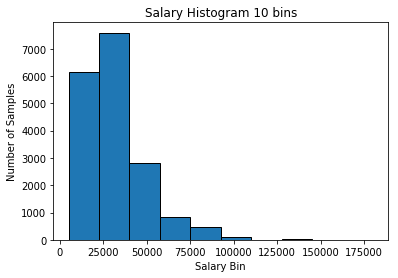

In [46]:
%matplotlib inline

plt.hist(Salaries_Plot['SalaryNormalized'], bins=10, edgecolor='black')
plt.title("Salary Histogram 10 bins")
plt.xlabel("Salary Bin")
plt.ylabel("Number of Samples")
plt.show()

# 3 Model Implementation

In [55]:
#set up cross validation

def run_kfold(model):
    
    X = Salaries_X
    Y = Salaries_Y
    
    kf = KFold(n_splits=10) #n_splits previously n_folds
    
    outcomes = []
    fold = 0
    
    for train_index, test_index in kf.split(X):
        fold += 1
        X_train, X_test = X.values[train_index], X.values[test_index]
        Y_train, Y_test = Y.values[train_index], Y.values[test_index]
        
        model.fit(X_train, Y_train)
        predictions = model.predict(X_test)
        
        accuracy = r2_score(Y_test, predictions) # can try mean absolute error instead
        outcomes.append(accuracy)
        print("Fold {0} accuracy: {1}".format(fold, accuracy))   
        
    mean_outcome = np.mean(outcomes)
    std_outcome=np.std(outcomes)
    print("Mean r2: {0}".format(mean_outcome)) 
    print("Standard Deviation: {0}".format(std_outcome)) 

## 3 A Linear Regression

In [56]:
model_lr = linear_model.LinearRegression()
run_kfold (model_lr)

predictions = model_lr.predict(Salaries_X_Test)
Test_Score = r2_score(Salaries_Y_Test, predictions)

print ("------------------\n Test Score: " + str(Test_Score))


Fold 1 accuracy: 0.44198787412528384
Fold 2 accuracy: 0.42667331572066847
Fold 3 accuracy: 0.4187964154154524
Fold 4 accuracy: 0.4410675259701794
Fold 5 accuracy: 0.4721211396851078
Fold 6 accuracy: -3.161524674820184e+19
Fold 7 accuracy: 0.42205856790967733
Fold 8 accuracy: 0.42300732623361026
Fold 9 accuracy: 0.4375115805244886
Fold 10 accuracy: 0.4919494121150183
Mean r2: -3.161524674820184e+18
Standard Deviation: 9.484574024460552e+18
------------------
 Test Score: -4.153440167297881e+16


In [57]:
mean_absolute_error(Salaries_Y_Test,predictions)

73716941952.95564

Look at features and coefficients

In [58]:
print(sorted(list(zip(model_lr.coef_, Salaries_X)))[0:10])

[(-189145330868913.66, 'residential support'), (-129368853427200.22, 'snr recruitment'), (-59587921246985.78, 'care assistant jobs'), (-5883093587010.844, 'Category_Graduate Jobs'), (-5883093581208.922, 'Category_Domestic help & Cleaning Jobs'), (-5883093579085.2295, 'Category_Travel Jobs'), (-5883093576107.538, 'Category_Hospitality & Catering Jobs'), (-5883093576015.272, 'Category_Admin Jobs'), (-5883093575709.888, 'Category_Maintenance Jobs'), (-5883093575178.993, 'Category_Customer Services Jobs')]


In [45]:
print(sorted(list(zip(model_lr.coef_, Salaries_X)),reverse=True)[0:10])

[(269084521706091.22, 'snr recruitment consultant'), (83964293625.89809, 'LocationNormalized_The City'), (83964292098.72908, 'LocationNormalized_London'), (83964289354.63266, 'LocationNormalized_South East London'), (83964288985.9075, 'LocationNormalized_Central London'), (83964287822.8159, 'LocationNormalized_Hertfordshire'), (83964286457.66087, 'LocationNormalized_Edinburgh'), (83964286434.57489, 'LocationNormalized_West Midlands'), (83964286367.19148, 'LocationNormalized_Reading'), (83964286176.97104, 'LocationNormalized_Berkshire')]


Coefficients seem very high, try regulatization and feature elimination. 

# Feature Selection

### Recursive Feature Elimination

scikit-learn:

Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), the goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a coef_ attribute or through a feature_importances_ attribute. Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html

In [59]:
rfe = RFE(model_lr)
fit = rfe.fit(Salaries_X[0:10000], Salaries_Y[0:10000]) #Sampling because of slow run time

In [60]:
sorted(list(zip(fit.ranking_,Salaries_X))[0:10])

[(1, 'LocationNormalized_Belfast'),
 (1, 'LocationNormalized_Hampshire'),
 (1, 'LocationNormalized_Leeds'),
 (1, 'LocationNormalized_Liverpool'),
 (1, 'LocationNormalized_London'),
 (1, 'LocationNormalized_Sheffield'),
 (3, 'LocationNormalized_Manchester'),
 (33, 'LocationNormalized_Other'),
 (67, 'LocationNormalized_Bristol'),
 (149, 'LocationNormalized_Birmingham')]

### Lasso Regularization

Linear Model trained with L1 prior as regularizer (aka the Lasso)

#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

In [61]:
reg = linear_model.Lasso(alpha = 0.5,max_iter=10000)
reg.fit(Salaries_X, Salaries_Y)
reg.score(Salaries_X, Salaries_Y)

0.4808442783580813

Example of Grid Search

In [74]:
from sklearn.metrics import make_scorer, r2_score, confusion_matrix

reg_gridsearch = linear_model.Lasso(random_state=42)
#Parameters to test
parameters = {'alpha':[0.5,1,3], # Constant that multiplies the L1 term. Defaults to 1.0.
             'normalize':[True,False]} #

# Compare parameters by score of model 
acc_scorer_lm = make_scorer(r2_score)

# Run the grid search
grid_obj_lm = GridSearchCV(reg_gridsearch, parameters, scoring=acc_scorer_lm)
grid_obj_lm = grid_obj_lm.fit(Salaries_X, Salaries_Y)

reg_gridsearch = grid_obj_lm.best_estimator_  #Select best parameter combination

In [78]:
reg_gridsearch # print out the optimal params so grid search does not need to be rerun

Lasso(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, positive=False, precompute=False, random_state=42,
   selection='cyclic', tol=0.0001, warm_start=False)

In [80]:
reg_gridsearch.fit(Salaries_X, Salaries_Y)
reg_gridsearch.score(Salaries_X, Salaries_Y)

0.47594535607371935

Print optimal parameters 

In [81]:
print('alpha (Constant that multiplies the L1 term):',grid_obj_lm.best_estimator_.alpha) 
print('normalize:',grid_obj_lm.best_estimator_.normalize)

alpha (Constant that multiplies the L1 term): 0.5
normalize: True


In [96]:
predictions_lasso=reg_gridsearch.predict(Salaries_X_Test)

In [97]:
mean_absolute_error(Salaries_Y_Test,predictions_lasso)

8694.773889872782

In [64]:
run_kfold (reg)

Fold 1 accuracy: 0.44299459579736256
Fold 2 accuracy: 0.427989566244645
Fold 3 accuracy: 0.4194247877520776
Fold 4 accuracy: 0.44136814194997154
Fold 5 accuracy: 0.473603222102566
Fold 6 accuracy: 0.4623067534040888
Fold 7 accuracy: 0.4222320269985771
Fold 8 accuracy: 0.42294396607848816
Fold 9 accuracy: 0.4387961583465326
Fold 10 accuracy: 0.49254536599367027
Mean r2: 0.444420458466798
Standard Deviation: 0.023192383290228


In [65]:
# can see more consistent results with regularization than regular linear regression

In [82]:
sorted(list(zip(reg.coef_, Salaries_X)),reverse=True)[0:10]
#Can see that regularized coefficeints are more reasonable 

[(35675.94677708074, 'nurse practitioner'),
 (20206.81963179331, 'intensive care'),
 (17277.39673877329, 'Category_Energy, Oil & Gas Jobs'),
 (13041.531751138406, 'self employed'),
 (10898.078738181799, 'finance manager'),
 (10065.842282653497, 'social worker'),
 (10033.801785172593, 'Category_Healthcare & Nursing Jobs'),
 (9665.217110175916, 'LocationNormalized_The City'),
 (9256.45888329068, 'systems engineer'),
 (9093.641997980198, 'care assistant job')]

In [ ]:
rfe_lasso = RFE(reg)
fit_lasso = rfe_lasso.fit(Salaries_X[0:10000], Salaries_Y[0:10000]) #Sampling because of slow run time

In [84]:
sorted(list(zip(model_lr.coef_, Salaries_X))[0:10])

[(-133207206779.49579, 'LocationNormalized_Sheffield'),
 (-133207206102.71036, 'LocationNormalized_Belfast'),
 (-133207204620.18347, 'LocationNormalized_Manchester'),
 (-133207204515.2962, 'LocationNormalized_Leeds'),
 (-133207204285.05678, 'LocationNormalized_Liverpool'),
 (-133207203265.15285, 'LocationNormalized_Other'),
 (-133207202733.08762, 'LocationNormalized_Birmingham'),
 (-133207202331.39232, 'LocationNormalized_Bristol'),
 (-133207201058.79599, 'LocationNormalized_Hampshire'),
 (-133207195179.7651, 'LocationNormalized_London')]

### PCA - Example

In [236]:
# does not show any improvements - higher score with more components

In [85]:
from sklearn.decomposition import PCA
pca = PCA(n_components=150)
pca.fit(Salaries_X)
PCA_X = pca.transform(Salaries_X)
PCA_X_Test = pca.transform(Salaries_X_Test)
model_lr_pca = linear_model.LinearRegression()
model_lr_pca.fit(PCA_X,Salaries_Y)

predictions_pca_train = model_lr_pca.predict(PCA_X)
predictions_pca_test = model_lr_pca.predict(PCA_X_Test)

print ("Train r2 Score")

print (r2_score(Salaries_Y, predictions_pca_train))  

print ("Test r2 Score")

print (r2_score(Salaries_Y_Test,predictions_pca_test))

Train r2 Score
0.33889905686064303
Test r2 Score
0.32501665552061254


In [87]:
#------------------------------------------------------------------------------
#Extra for Assignment 2
#------------------------------------------------------------------------------
'''
# thresh = require that many non-NA values

Salaries = Salaries.dropna(thresh=len(Salaries) - 10000, axis=1) #drop columns with too many NAs

# Drop or explore columns which have too many unique values are will be difficult to encode

Salaries_X.drop([col for col, val in Salaries_X.nunique().iteritems() if val > 500], axis=1, inplace = True) '''

'\n# thresh = require that many non-NA values\n\nSalaries = Salaries.dropna(thresh=len(Salaries) - 10000, axis=1) #drop columns with too many NAs\n\n# Drop or explore columns which have too many unique values are will be difficult to encode\n\nSalaries_X.drop([col for col, val in Salaries_X.nunique().iteritems() if val > 500], axis=1, inplace = True) '

# Neural Network

https://scikit-learn.org/stable/modules/neural_networks_supervised.html

In [88]:
clf = MLPRegressor(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(10,8,4), random_state=1, max_iter=1000)
clf.fit(Salaries_X, Salaries_Y)

MLPRegressor(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10, 8, 4), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [92]:
clf.score(Salaries_X, Salaries_Y)

0.7666722979065587

In [91]:
clf.score(Salaries_X_Test, Salaries_Y_Test) #overfitting..

0.14664792249631842

In [221]:
# run_kfold(clf)